In [90]:
import numpy as np # linear algebra
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

In [91]:
image_list = []
label_list = []

folder = "coins/br-coins/all"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

for file in onlyfiles:
    image_list.append(np.array(cv2.imread(folder + '/' + file)))
    label_list.append(file.split('_')[0])

images = np.array(image_list)
labels = np.array(label_list)

In [64]:
'''folder = "coins/br-coins/all"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
y_data = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    label_in_file = _file.find("_")
    coin = int(_file[0:label_in_file])
    mapping = {5: 0, 10: 1, 25: 2, 50: 3, 100: 4}
    y_data.append(mapping[coin])
    
print("Files in train_files: %d" % len(train_files))

# Original Dimensions
image_width = 640
image_height = 480
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)

i = 0
for _file in train_files:
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print("%d images to array" % i)
print("All images to array!")'''

'folder = "coins/br-coins/all"\nonlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]\n\nfrom scipy import ndimage\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img\n\ntrain_files = []\ny_data = []\ni=0\nfor _file in onlyfiles:\n    train_files.append(_file)\n    label_in_file = _file.find("_")\n    coin = int(_file[0:label_in_file])\n    mapping = {5: 0, 10: 1, 25: 2, 50: 3, 100: 4}\n    y_data.append(mapping[coin])\n    \nprint("Files in train_files: %d" % len(train_files))\n\n# Original Dimensions\nimage_width = 640\nimage_height = 480\nratio = 4\n\nimage_width = int(image_width / ratio)\nimage_height = int(image_height / ratio)\n\nchannels = 3\nnb_classes = 1\n\ndataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)\n\ni = 0\nfor _file in train_files:\n    img = load_img(folder + "/" + _file)  # this is a PIL image\n    img.thumbnail((image_width, image_heig

In [95]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)
        #resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

        frames.append(resized)

    return np.array(frames), radiuses

In [99]:
import os
for i in ['5', '10', '25', '50', '100']:
    try:
        os.makedirs('coins/br-coins/circles/' + i)
    except:
        pass

scaled = []
scaled_labels = []
radiuses = []
count = 0
for nominal, image in zip(labels, images):
    prepared, radius = extract_coins(image, to_size=120)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)
        radiuses.append(radius[0])
        cv2.imwrite('coins/br-coins/circles/' + nominal + '/' + str(count) + '.jpg', prepared[0])
        count += 1

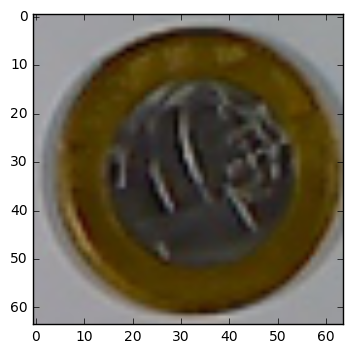

100


In [94]:
pixels = np.array(img, dtype='int')
#pixels = pixels.reshape((64, 64, 3))
plt.imshow(scaled[0])
plt.show()
print(scaled_labels[0])

In [84]:
scaled[0].shape

(64, 64, 3)

In [85]:
images[0].shape

(480, 640, 3)